In [1]:
import os

PROJECT_ROOT = '/Users/joelthomas/Library/CloudStorage/OneDrive-Personal/Documents/My Documents/UNIVERSITY/Masters/M2 Finance/Monetary and financial economics/Project/Code'
DATA_DIR = '/Users/joelthomas/Library/CloudStorage/OneDrive-Personal/Documents/My Documents/UNIVERSITY/Masters/M2 Finance/Monetary and financial economics/Project/Code'
GRAPHS_DIR = os.path.join(PROJECT_ROOT, 'latex', 'graphs')
GRAPHS_WEB_DIR = os.path.join(PROJECT_ROOT, 'nlp_code', 'latex', 'graphs')

RANDOM_SEED = 101
PROFIT_MARGIN = .15
LIQUIDATION_RECOVERY = .3

In [2]:
import os
import pickle
from datetime import datetime
# import numba as nb
import scipy
import matplotlib.pyplot as plt

from io import StringIO
import sys


import numpy as np
import pandas as pd
from itertools import compress


def get_dt_index(df: pd.DataFrame, dt_index_col=None, is_rename_date: bool = True):
    if dt_index_col is None: dt_index_col = 'date'
    df = df.set_index(pd.DatetimeIndex(df[dt_index_col].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))))
    if dt_index_col in df.columns:
        df = df.drop(dt_index_col, axis=1)
    if is_rename_date: df.index.name = 'date'
    return df


def load_pd_df(file_name, file_path=None, is_replace_nan=True, **kwargs):
    file_type = file_name.split('.')[-1]

    if file_path is None:
        file_path = DATA_DIR

    if file_type == 'csv':
        return pd.read_csv(os.path.join(file_path, file_name), **kwargs)
    elif file_type == 'xlsx':
        return pd.read_excel(os.path.join(file_path, file_name), **kwargs)
    elif file_type == 'feather':
        df = pd.read_feather(os.path.join(file_path, file_name), **kwargs)
        # if is_replace_nan:
        #     warnings.warn("replacing nan for feather format, pass 'is_replace_nan=False' to disable")
        #     df = df.replace({'nan': np.nan})
        return df
    else:
        raise KeyError(f"{file_type} unknown")


def save_pd_df(df, file_name: str, file_path=None):
    file_type = file_name.split('.')[-1]
    if file_path is None:
        file_path = '/Users/joelthomas/Library/CloudStorage/OneDrive-Personal/Documents/My Documents/UNIVERSITY/Masters/M2 Finance/Monetary and financial economics/Project/Code'

    if file_type == "csv":
        df.to_csv(os.path.join(file_path, file_name))
    elif file_type == "feather":
        df.to_feather(os.path.join(file_path, file_name))
    else:
        raise KeyError(f"{file_type} unknown")




class Capturing(list):
    def __init__(self, file_name: str):
        self.file_name = file_name
        pass

    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        return self

    def __exit__(self, *args, **kwargs):
        self.extend(self._stringio.getvalue().splitlines())
        del self._stringio
        sys.stdout = self._stdout
        write_to_txt("\n".join(self), self.file_name, file_dir=os.getcwd())


def write_to_txt(output: str, file_name, file_dir=None):
    if file_dir is None: file_dir = GRAPHS_DIR
    f = open(os.path.join(file_dir, file_name), 'w+')
    f.write(output)
    f.close()
    pass


def save_pkl(file: dict, f_name: str, f_path: str = None):
    if f_path is None:
        f_path = "_"
    t = open(os.path.join(f_path, f"{f_name}"), "wb+")
    pickle.dump(file, t)
    t.close()
    pass

def save_fig(fig, f_name: str, f_path: str = None):
    if f_path is None:
        f_path = GRAPHS_DIR
    fig.savefig(os.path.join(f_path, f_name))
    pass


def load_pickle(f_name, f_path=None):
    if f_path is None:
        f_path = "_"
    t = open(os.path.join(f_path, f_name), 'rb')
    file = pickle.load(t)
    t.close()
    return file


def arr_min_max_scale(arr):
    if arr.min() != arr.max():
        return (arr - arr.min()) / (arr.max() - arr.min())
    else:
        return arr


def pd_join_freq(df1, df2, freq: str = 'D', keep_left_index: bool = True, **kwargs):
    df1, df2 = df1.copy(), df2.copy()
    
    for d in [df1, df2]:
        assert d.index.name != freq, "pls change index name"
        
    if keep_left_index:
        df1[df1.index.name] = df1.index
        # df2['index_right'] = df2.index
    
    df1[freq] = df1.index.to_period(freq)
    df2[freq] = df2.index.to_period(freq)
    
    df = pd.merge(df1, df2, on=freq, **kwargs).set_index(freq) #, axis=1)
    df.index = df.index.to_timestamp()
    if keep_left_index:
        df = df.set_index(df1.index.name, drop=False)
    return df


def cross_corr(arr1, arr2, lags: int = 10, is_plot: bool = True, **kwargs):
    assert arr1.shape == arr2.shape, "please ensure both arrays are of same dimensions"
    
    lags = min(len(arr1)-1, lags)
    y1, y2 = 2/np.sqrt(len(arr1)), -2/np.sqrt(len(arr1))
    corr = scipy.signal.correlate(arr2, arr2, mode='full', **kwargs)
    corr = corr[len(arr1)-1-lags: len(arr2)-1+lags]

    idx = np.linspace(-lags,lags, lags*2)
    
    if is_plot:
        fig, ax = plt.subplots(1,1)        
        ax.fill_between(idx, y1, y2, alpha=.2)
        ax.axhline(y=0, color='black')
        ax.bar(idx, corr, color='blue', width=.5)
        ax.set_xlabel(f'no. of lags')
        ax.set_ylabel(f'correlation')
        ax.set_title(f"Cross correlation with {lags} lags")
        plt.tight_layout()
        
        return idx, corr, y1, y2, fig
    
    else:
        return idx, corr, y1, y2

In [3]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def adf_test_summary(ser):
    # ADF H0: there is a unit root

    specs = {'constant': 'c', 'constant trend': 'ct', 'constant ltend, qtrend': 'ctt', 'none': 'n'}
    results = {}

    for pretty, spec in specs.items():
        adf, pval, ulag, nobs, cval, icb = adfuller(ser, regression=spec)
        keys = ['adf-stat', 'p-value', 'lags', 'obs', *cval.keys(), 'inf crit']
        res = [adf, pval, ulag, nobs, *cval.values(), icb]
        results[pretty] = dict(zip(keys, res))

    if ser.name is not None:
        title = ser.name.upper()
    else:
        title = ''

    print('-' * 77)
    print(f'ADF Test {title}: H0 there is a unit root')
    print('-' * 77)
    print(pd.DataFrame(results).transpose().round(3).iloc[:, :-1])
    print('\n')

    pass


from io import StringIO
import sys


class Capturing(list):
    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        return self

    def __exit__(self, *args):
        self.extend(self._stringio.getvalue().splitlines())
        del self._stringio
        sys.stdout = self._stdout


def plot_df(df, n_cols: int = 3, fig_size: tuple = (5, 2)):
    n_cols = min(n_cols, df.shape[1])
    rows = int(np.ceil(df.shape[1] / n_cols))

    fig, axes = plt.subplots(rows, n_cols, figsize=(n_cols * fig_size[0], rows * fig_size[1]))
    for i, ax in enumerate(axes.reshape(-1)):
        if i > df.shape[1] - 1: continue
        ax.plot(df.iloc[:, i].dropna())
        ax.set_title(df.iloc[:, i].name)

    plt.tight_layout()
    return fig, axes


def simulate_brownian_motion(N, T, r, sigma, P0, n):
    dt = T / n

    paths = np.zeros((N, n + 1))
    paths[:, 0] = np.log(P0)  # Use the natural logarithm of the initial price

    for i in range(1, n + 1):
        # Generate normal random shocks
        dW = np.random.normal((r - 0.5 * sigma**2) * dt, sigma * np.sqrt(dt), N)

        # Update paths using the volatility-adjusted shocks and natural logarithms
        paths[:, i] = paths[:, i - 1] + dW

    # Exponentiate to get the simulated paths of prices
    paths = np.exp(paths)
    
    return paths

def simulate_return_draws(N_sim, T_sim, P0, rets: np.array):
        
    simulations = np.zeros((N_sim, T_sim))
    
    for i in range(0, N_sim):
        ind = np.random.randint(0, len(rets), T_sim)
        simulations[i] = rets[ind]
    
    # cumulated product departing from p0
    simulations = simulations + 1
    simulations[:, 0] = simulations[:, 0] * P0
    simulations = np.cumprod(simulations, axis=1)

    return simulations

def get_lookback_price(sims, T, N, r_e, P0):
    sim_max = sims.max(axis=1)
    G0 = np.exp(-r_e * T) * 1 / N * np.sum(sim_max) - P0
    sigma_y = 1 / N * np.sum((sim_max - np.mean(sim_max)) ** 2)
    print(G0, sigma_y)
    
    # mu = np.linspace(P0, P0 + G0, T_sim)
    
    # upper = np.linspace(P0, P0 + G0 + G0 * 1.96 * sigma_y, T) 
    # lower = np.linspace(P0, P0 + G0 - G0 * 1.96 * sigma_y, T) 
    u, l = G0 + 1.96 * sigma_y, G0 - 1.96 * sigma_y

    return sim_max, G0, mu, u, l, sigma_y

def write_to_txt(output: str, file_path):
    f = open(file_path, 'w+')
    f.write(output)
    f.close()
    pass

In [4]:
import pymc as pm
from pymc_experimental.statespace.core.statespace import PyMCStateSpace

from pymc_experimental.statespace.utils.constants import (
    ALL_STATE_DIM,
    ALL_STATE_AUX_DIM,
    OBS_STATE_DIM,
    SHOCK_DIM,
)
from pymc_experimental.statespace.models.utilities import make_default_coords

import pytensor.tensor as pt
import jax
import numpyro

jax.config.update("jax_platform_name", "cpu")
numpyro.set_host_device_count(4)

In [5]:
import pandas as pd
import numpy as np
import sympy as sp

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
import os
import scipy

In [6]:
import eurostat

In [7]:
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.iolib.summary2 import summary_col
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [8]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [9]:
plt.rcParams["figure.figsize"] = (12,3)

# Question 1
"Expand the data base for proxies of your policy target inflation and your policy target for the longest period. Provide the link to the database (FRED, ECB, BdF, BoE, IMF, WB and so on) related to your time series. For example, do no use the CPI index but its growth rate (or difference of log) which measure inflation."

## load data

In [10]:
codes = eurostat.get_toc_df()
[i for i in codes['title'] if 'interest'.lower() in i.lower()];
codes[codes['title'] == 'Interest rates - monthly data'];

#### The Harmonised Index of Consumer Prices (EUROSTAT, 2024)
This monthly series gives comparable measures of inflation calculated from the set of Consumer Price Indicies. It is an indicator of inflation that measures the change over time of consumer goods and services. Importantly, the HICP is the official measure of consumer price inflation in the euro area for the purposes of monetary policy and hence is the most suitable measure for the policy rule. 

In [11]:
# cpi
data = eurostat.get_data('PRC_HICP_MIDX', filter_pars={'geo': ['EA20']})
df = pd.DataFrame(data[1:], columns=data[0])
cpi = df[(df['freq'] == 'M') & (df['unit'] == 'I05') & (df['geo\\TIME_PERIOD'] == 'EA20') & (df['coicop'] == 'CP00')].T.dropna().iloc[4:]
cpi.columns = ['cpi']
cpi.index = [datetime.strptime(x, "%Y-%m") for x in cpi.index]

save_pd_df(cpi.reset_index(names=['date']), 'cpi.feather')

#### Private Sector Credit Flow (EUROSTAT, 2024)
The private sector credit flow represents the net amount of liabilities (debt securities and loans) in which the sectors Non-financial corporations and households and non-profit serving households have incurred throughout the year. 

The TIPSPC20 is presented both as percent of GDP and in millions of units of national currency (MIO_NAC), which is utilised here. The institutional sectors taken into account are non-financial corporations (principal activity is production of goods and non-financial services), households and non-profit institutions serving households (principal resources are voluntary contributions in cash or in kind).

This annual series is key for policy makers to monitor the growth of credit in an economy, assess financial stability and contextualise decisions surrounding monetary policy, like the setting of interest rates.

In [12]:
# private sector credit
filt = 'TIPSPC20'
data = eurostat.get_data(filt) #, filter_pars={'geo': ['EA19']})
df = pd.DataFrame(data).T.set_index(0).T
pc_gdp = df[(df['geo\\TIME_PERIOD'] == 'EA20') & (df['unit'] == "MIO_NAC")].T.iloc[7:]
pc_gdp.columns = ['pc_gdp']
pc_gdp.index = [datetime(int(str(x)),1,1) for x in pc_gdp.index]

save_pd_df(pc_gdp.reset_index(names=['date']), 'pc_gdp.feather')

#### General Government Gross Debt (EUROSTAT, 2024)
Government debt is the total consolidated gross debt at nominal (face) value outstanding at the end of the year and consolidated between, and within the sectors of general government. The data is in millions of national currency (MIO_NAC).

The government debt has implications for fiscal policy. High levels of debt to GDP imply difficulty in meeting budgetary requirements and may precede lower levels of consumer confidence.

In [13]:
# public debt to gdp
filt = 'TIPSGO20'
data = eurostat.get_data(filt) #, filter_pars={'geo': ['EA19']})
df = pd.DataFrame(data).T.set_index(0).T
pd_gdp = df[(df['unit'] == "MIO_NAC")].T.iloc[7:].dropna().sum(axis=1).rename('pd_gdp')
pd_gdp = pd.DataFrame(pd_gdp)
pd_gdp.index = [datetime(int(x[:4]), int(x[-1])*3-2, 1) for x in pd_gdp.index]

save_pd_df(pd_gdp.reset_index(names=['date']), 'pd_gdp.feather')

#### Gross Domestic Product (GDP) at Market Prices (EUROSTAT, 2024)
This is a quarterly time series measured in current prices in millions of units of national currency. GDP is a measure of production activity of resident producers and defines the value of all goods and services produced in the Euro area. This data is seasonally adjusted.

In [14]:
# gdp
filt = 'TIPSAU20'
data = eurostat.get_data(filt) #, filter_pars={'geo': ['EA19']})
df = pd.DataFrame(data).T.set_index(0).T
gdp = df[(df['s_adj'] == "NSA")]
gdp = gdp.iloc[:, 5:].rename(columns={'geo\TIME_PERIOD': 'country'})
gdp = pd.DataFrame(gdp.sum(), columns=['gdp'])
gdp.index = [datetime(int(x[:4]), int(x[-1])*3-2, 1) for x in gdp.index]

save_pd_df(gdp.reset_index(names=['date']), 'gdp.feather')

#### Interest Rates (EUROSTAT, 2024)
This is a seasonally unadjusted monthly time series of 3-month averaged interest rates. The indicator extracted is the short-term interest rates. This is the day-to-day money market interest rates. It is an average for the euro area (Euro OverNight Index Average) and then averaged over 3-months. 

In [15]:
# interest rates
filt = 'EI_MFIR_M'
data = eurostat.get_data(filt) #, filter_pars={'geo': ['EA19']})
df = pd.DataFrame(data).T.set_index(0).T
ir = df[(df['geo\\TIME_PERIOD'] != "EA28") & (df['geo\\TIME_PERIOD'] != "EU27_2020") & (df['indic'] == "MF-3MI-RT")]
ir = pd.DataFrame(ir.iloc[:, 5:].median(axis=0), columns=['ir'])
ir.index = [datetime(int(x[:4]), int(x[-2:]), 1) for x in ir.index]
ir /= 100

save_pd_df(ir.reset_index(names=['date']), 'ir.feather')

## Summary of Datasets
The description of the data is presented here. However, the data can be downloaded, and transformations performed, directly with this notebook using the eurostat package. In other words, the results are replicable with this notebook alone.

| Eurostat Code | Link | Description | Frequency | Transformation |
| --- | --- | --- | --- | --- |
| PRC_HICP_MIDX | https://ec.europa.eu/eurostat/databrowser/view/PRC_HICP_MIDX__custom_1439028/default/table?lang=en | Harmonised index of consumer prices (HICP) (prc_hicp)| Monthly | Logged and first differenced for monthly inflation rate. Later compounded for annualised inflation. | 
| TIPSPC20 | https://ec.europa.eu/eurostat/databrowser/view/tipspc20/default/table | Private sector credit flow (tipspc) | Annual || 
| TIPSGO20 | https://ec.europa.eu/eurostat/databrowser/view/tipsgo20/default/table?lang=en | General government gross debt (EDP concept), consolidated - quarterly data | Quarterly | | 
| TIPSAU20 | https://ec.europa.eu/eurostat/databrowser/view/tipsau20/default/table?lang=en&page=SCA | Gross domestic product (GDP) at market prices - quarterly data | Quarterly |  | 
| EI_MFIR_M | https://ec.europa.eu/eurostat/databrowser/view/EI_MFIR_M__custom_5797138/default/table?lang=en | Monetary and financial indicators (ei_mf). Interest rates monthly data. This dataset provides interest rates that are not seasonally adjusted for   | Monthly | | 

Reference: EUROSTAT, 2024

## Merge

In [16]:
df = pd.DataFrame(index=pd.date_range(start=datetime(1999,1,1), end=datetime.today()))
for d in ['cpi', 'ir', 'gdp', 'pd_gdp', 'pc_gdp']:
    df = df.join(load_pd_df(f'{d}.feather').set_index('date'))
df = df.dropna(thresh=1)

## Transformations
Here, we take the difference in the logged Consumer Price Index to calculate the monthly inflation rate.

For GDP, the Hodrick-Prescott (HP) filter is applied to separate the series into the cyclical component and trend (Hodrick and Prescott, 1997). The trend component contains a deterministic of stochastic trend and is supposed to be more sensitive to long-term fluctuations than short-term. The filter is the solution to the following problem:
$$
y_{t} = \tau_{t} + c_{t}
$$ $$
min_{\{\tau_{t}\}} \{ \Sigma^{T}_{t=1} (y_{t} - \tau_{t})^2 + \lambda \Sigma^{T-1}_{t=2} [(\tau_{t+1} - \tau_{t}) - (\tau_{t} - \tau_{t-1})]^{2} \}
$$

where $y_t$ is the original series, $\tau_{t}$ is the trend component and $c_{t}$ is the cyclical component. The HP filter minimises the deviation of the original series from the trend as well as the curvature of the estimated trend (OECD, 2019). The cyclical component is renamed gdp_cyc and the trend component renamed gdp_trend.

In [17]:
#Note for Lukas: df = df.join(trend.rename('gdp_trend')) was originally df = df.join(cyc.rename('gdp_trend')). There was a mistake in the code.

In [18]:
df['pi_M'] = np.log(df.cpi).diff()

cyc, trend = hpfilter(np.log(df.gdp.dropna()))
df = df.join(cyc.rename('gdp_cyc'))
df = df.join(trend.rename('gdp_trend'))
df['ir_diff'] = df.ir.diff()

df['M'] = df.index.month

In [19]:
## astype

In [20]:
dict_parse = {'cpi': float,
 'ir': float,
 'gdp': float,
 'pd_gdp': float,
 'pc_gdp': float,
 'pi_M': float,
'pi_M': float,
 'gdp_cyc': float,
 'gdp_trend': float,
 'M': 'category'}

In [21]:
df = df.astype(dict_parse)
df = df.asfreq('MS')

# Question 2
"Check if there is seasonal adjustment or not: you may regress your time series on seasonal dummies. CHECK if the scale of the time series is comparable: for example, monthly Inflation is not multiplied by 12 to have an "annual" scale for this monthly data, whereas the monthly Fed funds rate is multiplied by 12. You will have incredible REAL interest rates. COMMENT. Then adjust for the same scale, because in regressions, the ratio of standard errors of each variables will be multiplied or divided by 12 because of these difference of scale."

pi_M is a variable created from the monthly CPI index PRC_HICP_MIDX. It is the first difference of the logged CPI giving us the monthly inflation rate. In calculating inflation in this way, we have avoided the annualisation of monthly inflation rates. The figure commonly presented by central banks is the yearly inflation for a given month. They say "inflation this month is 4%". This does not mean that prices are going to rise by 4% this month, it means that as of this month, prices are expected to rise by 4% over the year given the monthly change in CPI. As it stands, estimating the policy rule from the monthly inflation data but with an annualised interest rate would give us an extreme policy rule. The 'F' parameter that we saw in class would be extremely large because we would be using interest rates over one year as a response to inflation over one month.

The inflation rate must be adjusted so that it coincides with the interest rate being annualsied. To do this, the inflation rate is compounded over the previous 12 months. We lose the first 12 months of observations, and the first pi_Y observation we have for 2000-12-01 is the product of 1+pi_M for the 12 previous months. We now have a match between the annualised interest rate and annualised inflation rate.

Following this, we check for seasonality. Seasonal adjustment to data attempts to remove predictable seasonal patterns from data. Seasonal adjustments make it easier to observe the cyclical, underlying trend, and other nonseasonal movements in the series.(Bureau of Labor Statistics, 2022).

There is clear cyclicality in the series. For the monthly inflation, all the monthly dummy coefficients are significant at least to the 90% confidence level. Only one has a p-value above 0.01. The residuals of the OLS regression are saved as pi_M_resid, the non-cylical monthly (non-annualised) inflation rate. Note that no constant is included in these regressions to avoid the dummy variable trap. The dummy variable trap occurs if there are N categories and each observation falls in one of the N categories but no more. If we use all N dummy variables as regressors and include a constant, then the regressors will fail because of perfect multicollinearity. To avoid this, use N dummies and no constant, or N-1 dummies and a constant (Stock & Watson, 2020).

The same can be said for GDP_cyc. There is some degree of seasonality detected by an OLS with quarterly dummies after the HP filter's application, but only half of the coefficients are significant. For the GDP_trend, which should be the long-run trend of GDP and be unchanged by quarterly variations, all coefficients are significant suggesting the HP filter has been unsuccessful in extracting the seasonality component. The residuals from both regressions are extracted for cyclical and trend GDP with seasonality removed.

In [22]:
df['pi_M']

1999-01-01         NaN
1999-02-01         NaN
1999-03-01         NaN
1999-04-01         NaN
1999-05-01         NaN
                ...   
2023-10-01    0.000884
2023-11-01   -0.005588
2023-12-01    0.001639
2024-01-01   -0.003622
2024-02-01    0.006279
Freq: MS, Name: pi_M, Length: 302, dtype: float64

In [23]:
for col in ['pi_M', 'gdp_cyc', 'gdp_trend']:
    sub = df[[col, 'M']].dropna().copy()
    sub['M'] = sub.M.astype(int).astype('category')
    sub = sub.drop('M', axis=1).join(pd.get_dummies(sub['M'], prefix='m').iloc[:, :-1])
    x = sub.drop(col, axis=1)
    X = sm.add_constant(x).astype(int)
    ols = OLS(sub[col], X).fit()

    
    df = df.join(ols.resid.rename(f'{col}_resid'))
    print(col, '\n', ols.summary())

pi_M 
                             OLS Regression Results                            
Dep. Variable:                   pi_M   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     41.69
Date:                Tue, 02 Apr 2024   Prob (F-statistic):           1.66e-52
Time:                        09:06:45   Log-Likelihood:                 1288.7
No. Observations:                 290   AIC:                            -2553.
Df Residuals:                     278   BIC:                            -2509.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      4.574  

It is in the cell below that the annualised monthly inflation rate is calculated by compounding the monthly inflation rate. The compound annual growth rate formula is:
$$
\pi_Y = (\Pi^{12}_{i=1} (1+\pi_{M_i})) -1
$$
where a rolling product is used over the last 12 months. In this way, the inflation rate for the december is reflective of the overall inflation rate since January. The value of $\pi_Y$ for January is the product of all of the monthly inflation rates since February of the previous year et cetera.

In [24]:
df['pi_Y'] = (1+df.pi_M).rolling(12).apply(np.prod, raw=True) - 1
#df['pi_Y'] = df.pi_M * 12
#df['pi_Y_resid'] = (1+df.pi_M_resid).rolling(12).apply(np.prod, raw=True) - 1

for col in ['pi_Y']:
    sub = df[[col, 'M']].dropna().copy()
    sub['M'] = sub.M.astype(int).astype('category')
    sub = sub.drop('M', axis=1).join(pd.get_dummies(sub['M'], prefix='m').iloc[:, :-1])
    x = sub.drop(col, axis=1)
    X = sm.add_constant(x).astype(int)
    ols = OLS(sub[col], X).fit()

    
    df = df.join(ols.resid.rename(f'{col}_resid'))
    print(col, '\n', ols.summary())
   

pi_Y 
                             OLS Regression Results                            
Dep. Variable:                   pi_Y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.041
Method:                 Least Squares   F-statistic:                  0.001623
Date:                Tue, 02 Apr 2024   Prob (F-statistic):               1.00
Time:                        09:06:46   Log-Likelihood:                 712.21
No. Observations:                 279   AIC:                            -1400.
Df Residuals:                     267   BIC:                            -1357.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0213      0.004      5.423  

Hence, the data we use forewards is as follows:

| Data | Indicator| Range |
|---|---|---|
|Inflation Annualised (compounded)|pi_Y|2000-01-01 to 2024-02-01 |
|inflation annualised (compounded)residuals from seasonality regression (deseasonalised)| pi_Y_resid| 2000-12-01 to 2024-02-01|
|interest rate annualised| ir | 1999-01-01 to 2024-02-01|

# Question 3

"Copy a plot of the two time series over time."

### Inflation and Interest Rates

Recall that pi_Y is the compounded monthly inflation rate, using the previous 12 months' inflation rate as the inputs and pi_Y_resid is the residual from the seasonality regression. Not much changes between pi_Y and pi_Y_resid. The explanatory power of the monthly dummies was so weak, and the $R^2$ was so low that the time series' movements are almost identical, all that changes is there is a translation along the y-axis. This is because the intercept, which is essentially the average inflation rate (which we could say is the 'target' inflation), is subtracted from the series when we take the residual. This means that our pi_y_resid series is just pi_Y $- 0.0213$. This is like taking 2% off the inflation rate which the ECB has as its inflation target.

In the figure, we see stability in pi_Y at around 2% until the Global Financial Crisis in 2008. In 2008, the inflation rate rises initially, then cascades in mid-2008 towards the negatives in mid-2009. We can see from the descriptive statistics that the minimum inflation rate for pi_Y is -0.6%. The 'deviation from target' is -2.5%. Interest rates follow in a similar fashion, displaying what appears to be less variation than inflation, but tracking the trend of inflation to a large extent, falling to below 2% in 2009 and stauing there until the COVID-19 crisis and the extreme inflation beginning in 2021.

Pre-2021, the interest rate (ir) is highly responsive to the inflation rate, displaying almost no delay and following the inflation rate in tandem. However, the rate was far more stubborn and flat following the GFC, and was much slower to respond after the surge in inflation following the COVID-19 crisis. Rates were historically low following the GFC to stimulate growth and to offset the contractionary fiscal policies necessitated by the costs of the financial crisis. Inflation rates remained at or below target, so the interest rates stayed just in the positive.

Many banks were slow to respond to the inflationary surge following COVID-19 and the invasion of Ukraine because they wanted to ensure downside risks had declined (CEPR, 2024). The delays were to avoid acting too prematurely and exposing economies with already weakened monetary policy transmission mechanisms to financial market volatility, shocks and policy uncertainty. Confidence in the stability of inflation expectations and reluctance to change their guidance on the likely timing of rate increases and duration of asset purchases led to a more delayed but drawn-out response (CEPR, 2024).

<Axes: >

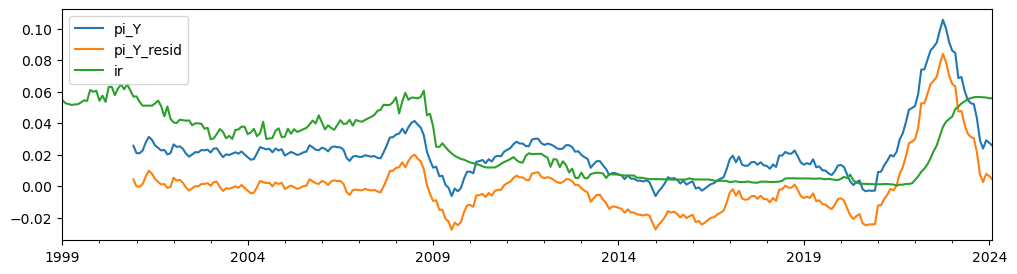

In [26]:
df[['pi_Y', 'pi_Y_resid', 'ir']].plot()

### GDP

Below you can observe the time series of the trend and cyclical components of GDP. Using the HP filter, quarterly GDP was separated into the cyclical and trend components. Naturally the cyclical component shows cyclicality. The cycles appear to be yearly, 

The trend however is a much smoother curve that levels our a little after the global financial crisis but is convex following that. 

<Axes: >

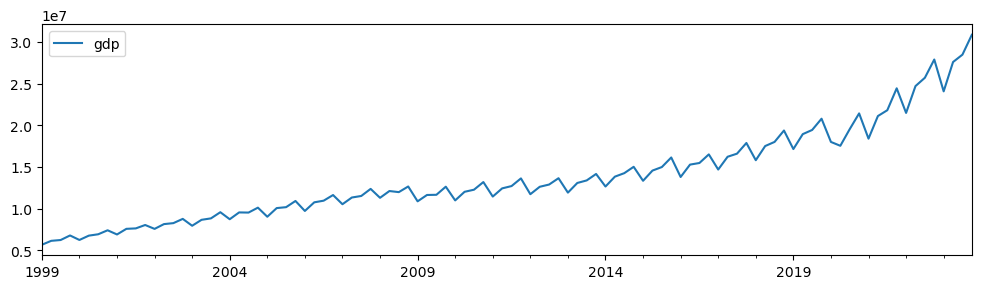

In [27]:
df[['gdp']].dropna().plot()

<Axes: >

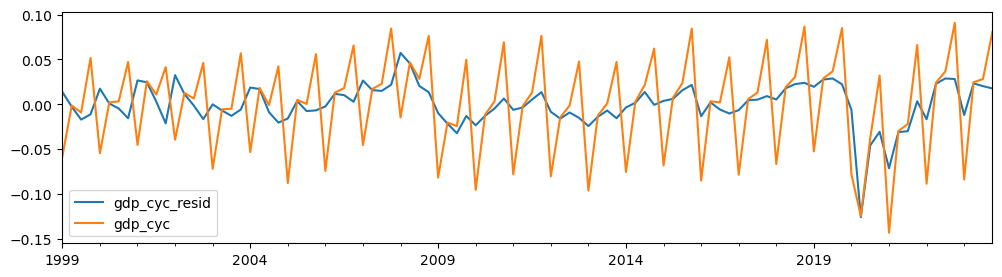

In [28]:
df[['gdp_cyc_resid', 'gdp_cyc']].dropna().plot()

<Axes: >

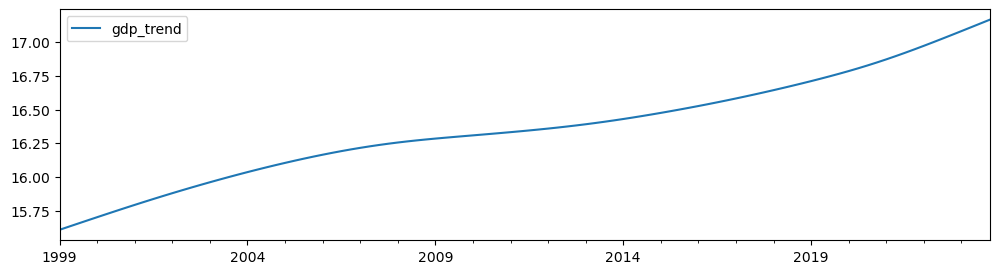

In [29]:
df[['gdp_trend']].dropna().plot()

# Question 4

"Report in a table univariate summary statistics: min max mean median standard errors of policy target and policy instrument."

In [30]:
df[['pi_Y_resid', 'pi_Y', 'ir']].dropna().describe()

,pi_Y_resid,pi_Y,ir
count,2.790000e+02,279.000000,279.000000
mean,9.973106e-18,0.021418,0.022745
std,1.887598e-02,0.018877,0.018911
min,-2.766090e-02,-0.006284,0.000380
25%,-1.003936e-02,0.011373,0.004700
50%,-1.694397e-03,0.019786,0.016902
75%,3.310514e-03,0.024804,0.039695
max,8.398968e-02,0.105601,0.060617


In [31]:
negative_pi_Y_dates = df[df['pi_Y'] < 0].index
print(negative_pi_Y_dates)

DatetimeIndex(['2009-06-01', '2009-07-01', '2009-08-01', '2009-09-01',
               '2009-10-01', '2014-12-01', '2015-01-01', '2015-02-01',
               '2015-03-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01'],
              dtype='datetime64[ns]', freq=None)


Dropping the observations for which inflation is missing, we are left with 279 monthly observations for interest rates, annualised inflation and annualised residual inflation. As mentioned above, the mean for pi_Y should be about 2% higher than the mean for pi_Y_resid because of the intercept term being almost an average of the inflation rate across the time series. This is observed here in this table.

The mean interest rate slightly exceeds the mean inflation rate despite the slow response following COVID. This is observed in the plot above with the interest rate line being above the inflation rate lines until the end of the sample. Median inflation and interest rates are around 2% and 1.7% respectively.

Throughout our sample, interest rates never exceed the zero lower bound. The lowest interest rate is 0.038%, practically zero. Inflation on the other hand does fall below zero. pi_Y reaches the negative both in 2009 and also in late 2014, 2015 and 2016. During this period there was simultaneously low inflation and low interest rates. Inflation is also negative during the COVID lockdowns from mid to late 2020.

# Question 5

"Estimate on the full period an AR(1) process and estimate the auto-correlation of its residual (let's denote it: AR(1)-AR(1))"

The series are first examined for presensce of a unit root. We do not expect a unit root given the graphs of the time series above and the Augmented Dickey Fuller tests confirm this. In no case are we able to reject the null that there is presence of a unit root.

In [32]:
lst_q5_cols = ['pi_Y', 'pi_Y_resid', 'ir']

In [33]:
for col in lst_q5_cols:
    adf_test_summary(df[col].dropna())

-----------------------------------------------------------------------------
ADF Test PI_Y: H0 there is a unit root
-----------------------------------------------------------------------------
                        adf-stat  p-value  lags    obs     1%     5%    10%
constant                  -1.842    0.360  12.0  266.0 -3.455 -2.872 -2.573
constant trend            -1.954    0.626  12.0  266.0 -3.993 -3.427 -3.137
constant ltend, qtrend    -2.900    0.345  12.0  266.0 -4.415 -3.855 -3.567
none                      -0.686    0.418  12.0  266.0 -2.574 -1.942 -1.616


-----------------------------------------------------------------------------
ADF Test PI_Y_RESID: H0 there is a unit root
-----------------------------------------------------------------------------
                        adf-stat  p-value  lags    obs     1%     5%    10%
constant                  -1.827    0.367  12.0  266.0 -3.455 -2.872 -2.573
constant trend            -1.941    0.633  12.0  266.0 -3.993 -3.427 -

The models estimated are:
$$
\pi_{t+1} = \lambda_{\pi}\pi_{t}+u_{t+1}  \ \ \ with \ \ \ u_{t+1} = \rho_{\pi}u_t +\epsilon_{t+1} $$
and for the 'residual' inflation
$$
\pi^{resid}_{t+1} = \lambda^{resid}_{\pi}\pi^{resid}_{t}+u_{t+1}  \ \ \ with \ \ \ u_{t+1} = \rho^{resid}_{\pi}u_t +\epsilon_{t+1} $$
and
$$
i_{t+1} = \lambda_{i}i_{t}+u_{t+1}  \ \ \ with \ \ \ u_{t+1} = \rho_{i}u_t +\epsilon_{t+1} $$

In [50]:

#lst_mod_resid, lst_rho_lambda = [], []

#for col in lst_q5_cols:    
#    ar_var = ARIMA(df[col], order=(1,0,0), trend = 'n').fit()
#    ar_res = ARIMA(ar_var.resid, order=(1,0,0), trend = 'n').fit()

#    lst_mod_resid.append(ar_res)
#    lst_rho_lambda.append((ar_var.params.loc['ar.L1'], ar_res.params.loc['ar.L1']))

#summary_col(lst_mod_resid, model_names=lst_q5_cols, stars=True)

In [115]:
for col in lst_q5_cols:    
    ar_var = ARIMA(df[col], order=(1,0,0), trend = 'n').fit()
    print(f"Model = {col}")
    print(f"Summary for ARIMA model of {col}:")
    print(ar_var.summary())
    print("\n\n") 
    
    ar_res = ARIMA(ar_var.resid, order=(1,0,0), trend = 'n').fit()
    print(f"Summary for ARIMA model of residuals of {col}:")
    print(ar_res.summary())
    print("\n\n")
    print("--"*50)
    print("--"*50)

    lst_mod_resid.append(ar_res)
    lst_rho_lambda.append((ar_var.params.loc['ar.L1'], ar_res.params.loc['ar.L1']))

Model = pi_Y
Summary for ARIMA model of pi_Y:
                               SARIMAX Results                                
Dep. Variable:                   pi_Y   No. Observations:                  302
Model:                 ARIMA(1, 0, 0)   Log Likelihood                1184.818
Date:                Tue, 02 Apr 2024   AIC                          -2365.636
Time:                        12:03:42   BIC                          -2358.215
Sample:                    01-01-1999   HQIC                         -2362.667
                         - 02-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9927      0.004    227.779      0.000       0.984       1.001
sigma2      1.181e-05   5.98e-07     19.739      0.000    1.06e-05     1.3e-05
Ljung-

The model results are:
|Autocorrelation parameter| Value| Autocorrelation of residual| value| 
|---|---|---|---|
|$\lambda_{\pi}$| $0.9927^{***}$|$\rho_{\pi}$|$0.2300^{***}$|
|$\lambda^{resid}_{\pi}$|$0.9834^{***}$|$\rho^{resid}_{\pi}$| $0.3063^{***}$|
|$\lambda_{i}$|$0.9964^{***}$| $\rho_{i}$| $-0.0711$|

So
$$
\pi_{t+1} = 0.9927\pi_{t}+u_{t+1}  \ \ \ with \ \ \ u_{t+1} = 0.2300u_t +\epsilon_{t+1} $$
and for the 'residual' inflation
$$
\pi^{resid}_{t+1} = 0.9834\pi^{resid}_{t}+u_{t+1}  \ \ \ with \ \ \ u_{t+1} = 0.3063u_t +\epsilon_{t+1} $$
and
$$
i_{t+1} = 0.9964i_{t}+u_{t+1}  \ \ \ with \ \ \ u_{t+1} = -0.0711u_t +\epsilon_{t+1} $$

It would be unusual to observe negative autocorrelation of inflation. Although we haven't controlled for the contractionary/opposite effects of the interest rate on inflation, there remains some positive autocorrelation of inflation almost at 1. The same can be said for interest rates which are also autocorrelated with the coefficient 0.9964.

# Question 6

"Estimate the AR(2) model. Check your estimates are close to the following combination of parameters of the AR(1)-AR(1)"

In [44]:
#lst_mod_ar2 = []
#for col in lst_q5_cols:    
 #   ar_var = ARIMA(df[col], order=(2,0,0)).fit()
 #   lst_mod_ar2.append(ar_var)

In [45]:
#df_summary = summary_col(lst_mod_ar2, model_names=lst_q5_cols, stars=True, )
#df_summary.add_df(pd.DataFrame([(i[0] + i[1], i[0] * i[1]) for i in lst_rho_lambda], index=lst_q5_cols, columns=['rho+lamb', 'rho*lamb']).T)
#df_summary

The models estimated are:
$$
\pi_{t+1} = (\lambda_{\pi}+\rho_{\pi})\pi_{t} - \lambda_{\pi}\rho_{\pi}\pi_{t-1} + u_{t+1}  \ \ \ with \ \ \ u_{t+1} = \mu_{\pi}u_t+\epsilon_{t+1}
$$ $$
\pi^{resid}_{t+1} = (\lambda^{resid}_{\pi}+\rho^{resid}_{\pi})\pi^{resid}_{t} - \lambda^{resid}_{\pi}\rho^{resid}_{\pi}\pi^{resid}_{t-1} + u_{t+1} \ \ \ with \ \ \ u_{t+1} = \mu_{\pi}u_t+\epsilon_{t+1}
$$ and $$
i_{t+1} = (\lambda_i\rho_i)i_t - \lambda_i\rho_ii_{t-1}+u_{t+1} \ \ \ with \ \ \ u_{t+1} = \mu_iu_t+\epsilon_{t+1}
$$


In [39]:
for col in lst_q5_cols:    
    ar_var = ARIMA(df[col], order=(2,0,0), trend = 'n').fit()
    print(f"Summary for ARIMA model of {col}:")
    print(ar_var.summary())
    print("\n")
    
    ar_res = ARIMA(ar_var.resid, order=(1,0,0), trend = 'n').fit()
    print(f"Summary for ARIMA model of residuals of {col}:")
    print(ar_res.summary())
    print("\n") 

    lst_mod_resid.append(ar_res)
    lst_rho_lambda.append((ar_var.params.loc['ar.L1'], ar_res.params.loc['ar.L1']))

Summary for ARIMA model of pi_Y:
                               SARIMAX Results                                
Dep. Variable:                   pi_Y   No. Observations:                  302
Model:                 ARIMA(2, 0, 0)   Log Likelihood                1199.153
Date:                Tue, 02 Apr 2024   AIC                          -2392.307
Time:                        09:21:07   BIC                          -2381.176
Sample:                    01-01-1999   HQIC                         -2387.853
                         - 02-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3037      0.046     28.080      0.000       1.213       1.395
ar.L2         -0.3129      0.047     -6.665      0.000      -0.405      -0.221
sigma2      1.063e-

#### Model:
$$
\pi_{t+1} = (\lambda_{\pi}+\rho_{\pi})\pi_{t} - \lambda_{\pi}\rho_{\pi}\pi_{t-1} + u_{t+1}  \ \ \ with \ \ \ u_{t+1} = \mu_{\pi}u_t+\epsilon_{t+1}
$$

|Autocorrelation parameter AR(2)| Value|
|---|---|
|$\lambda_{\pi} + \rho_{\pi}$| $1.3037^{***}$|
|$- \lambda_{\pi}\rho_{\pi}$|$-0.3129^{***}$|
|$\mu_{\pi}$|$-0.0753$|

We have
|Parameters|Equation|Result (AR(1))|AR(2)| Comments|
|---|---|---|---|---|
|$\lambda_{\pi} + \rho_{\pi}$|$0.9927 + 0.2300$|$1.2227$|$1.3037$|Very close to AR(1) model: consistent|
|$- \lambda_{\pi}\rho_{\pi}$|$-0.9927 * 0.2300$|$-0.228321$|$-0.3129$|Fairly close to AR(1) model's result|

#### Model:
$$
\pi^{resid}_{t+1} = (\lambda^{resid}_{\pi}+\rho^{resid}_{\pi})\pi^{resid}_{t} - \lambda^{resid}_{\pi}\rho^{resid}_{\pi}\pi^{resid}_{t-1} + u_{t+1} \ \ \ with \ \ \ u_{t+1} = \mu_{\pi}u_t+\epsilon_{t+1}
$$

|Autocorrelation parameter AR(2)| Value|
|---|---|
|$\lambda^{resid}_{\pi} + \rho^{resid}_{\pi}$| $1.2973^{***}$|
|$- \lambda^{resid}_{\pi}\rho^{resid}_{\pi}$|$-0.3191^{***}$|
|$\mu_{\pi}$|$-0.0640$|

From our AR(1)-AR(1) and AR(2)-AR(1) models we have
|Parameters|Equation|Result (AR(1))|AR(2)| Comments|
|---|---|---|---|---|
|$\lambda^{resid}_{\pi} + \rho^{resid}_{\pi}$|$0.9834 + 0.3063$|$1.2897$|$1.2973$|Very close to AR(1) model: consistent|
|$- \lambda^{resid}_{\pi}\rho^{resid}_{\pi}$|$-0.9834 * 0.3063$|$-0.30121542$|$-0.3191$|Also very close|

### Model:
$$
i_{t+1} = (\lambda_i\rho_i)i_t - \lambda_i\rho_ii_{t-1}+u_{t+1} \ \ \ with \ \ \ u_{t+1} = \mu_iu_t+\epsilon_{t+1}
$$


|Autocorrelation parameter AR(2)| Value|
|---|---|
|$\lambda_{i} + \rho_{i}$| $0.8773^{***}$|
|$- \lambda_{i}\rho_{i}$|$-0.1199^{***}$|
|$\mu_{i}$|$-0.0182$|

We have
|Parameters|Equation|Result (AR(1))|AR(2)| Comments|
|---|---|---|---|---|
|$\lambda_{i} + \rho_{i}$|$0.9964 + -0.0711$|$0.9253$|$0.8873$|Fairly consistent with AR(1) model|
|$- \lambda_{i}\rho_{i}$|$-0.9964 * -0.0711$|$0.07084404$|$-0.1199$|This is inconsistent. This is because the AR(1) coefficient of the residuals is negative. It is statistically insignificant however, so these results do not necessarily imply a failure of the model.|

Overall, our estimates are close, particularly so for inflation. The only thing throwing the estimates off is the negative autocorrelation of the residuals in the AR(1)-AR(1) model for interest rates. The coefficient is low, but negative. The negative sign means we get an inconsistency when multiplying the $- \lambda_{i}\rho_{i}$. This leaves us with a positive product from the AR(1) model, but a negative value from the AR(2)-AR(1) models. It is worth noting that the p-value for this coefficient was 0.331 so it is statistically insignificant which implies this result is not as damning as at first glance.

# Question 7

"For an AR(p), p ≥ 2, for measuring persistence, should you consider the first auto- regressive parameter only or the sum of the auto-regressive parameters? A PhD student comes to you and states: look the auto-regressive parameter (the first one of the AR(1)) is 1.4, it is above a unit root. What do you answer to him?"

For an AR(P) process where p≥2, it would be incorrect to make this assumption based on the first autoregressive coefficient coefficient alone. The process is autoregressive to an order greater than just 1. We saw with the AR(2) models that the coefficient on the second lag is significant also so it would be a mistake to claim the process is explosive because of the coefficient of 1.4. We must consider the overall combined effects of the lags up to order P to determine whether there is a unit root or not. Indeed, for inflation the coefficient of the first lag is 1.3037 which is above 1 and hence indicates an explosive process. However, the coefficient for the second lag is 0.3129, and considering the sum of the autoregressive parameters gives 0.9908 which is less than 1. If 1.3037 was the only parameter is might suggest an explosive process but it is not the only coefficient: we must consider the sum of the autoregressive parameters.

The individual coefficients of an AR(p) process canot imply a unit root. Instead one needs to consider the combination of coefficients. More specifically, the eigenvalues of the coefficient matrix. Let $\mathbf{\Gamma}$ be the coefficient matrix of an AR(2) process, such that:
$ [a, b] $


In [98]:
lst_mod_ar2 = []
for col in lst_q5_cols:    
    ar_var = ARIMA(df[col], order=(2,0,0), trend = 'n').fit()
    lst_mod_ar2.append(ar_var)

In [99]:
phi1 = np.linspace(-2, 2, 100)
phi2 = np.linspace(-2, 2, 100)

stab1 = phi1 + 1
stab2 = 1 - phi1
stab3 = list([-1] * 100)
stab4 = -phi1 ** 2 / 4


Note that there is overlay of the coefs pi_Y_resid and coefs pi_Y on this figure


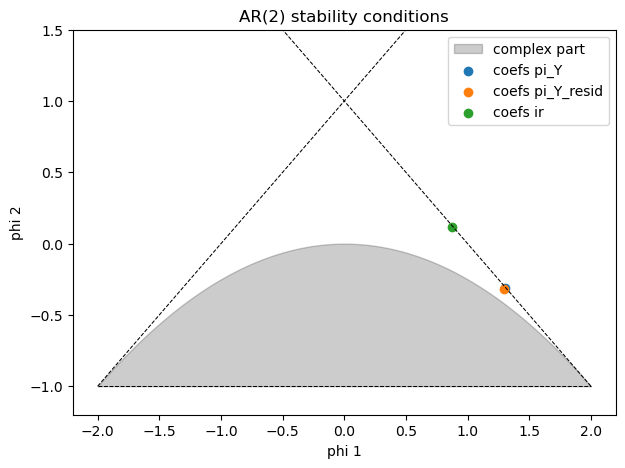

In [103]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.plot(phi1, stab1, color='black', linestyle='dashed', lw=.75)
ax.plot(phi1, stab2, color='black', linestyle='dashed', lw=.75)
ax.plot(phi1, stab3, color='black', linestyle='dashed', lw=.75)
# ax.fill_betweenx(stab4, stab1, phi1)
ax.fill_between(phi1, stab3, stab4, color='black', alpha=.2, linestyle='-', label='complex part')

for i, mod in enumerate(lst_mod_ar2):
    ax.scatter(*mod.params.values[:-1], label=f"coefs {lst_q5_cols[i]}")
    ax.set_ylim(bottom=-1.2, top=1.5)

ax.set_title("AR(2) stability conditions")
ax.set_xlabel("phi 1")
ax.set_ylabel("phi 2")

ax.legend()
print('\nNote that there is overlay of the coefs pi_Y_resid and coefs pi_Y on this figure')

Outside of the dashed triangle, the $|\phi_1 + \phi_2| > 1$ the system is explosive. The AR(2) processes satisfy the stability conditions and prove that the PhD student's comments are misguided. We can also confirm that the roots are real and not complex. Complex roots imply oscillatory behaviour. For inflation, one root is positive and the other negative which implies the system returns to equilibrium with oscillations. 

## simulate complex AR(2)

In [89]:
A = np.array([-.9, .9])
B = np.zeros((len(A), len(A)))
B[0, :] = A
B[1, 0] = 1
evals, evecs = np.linalg.eig(B)
evals > 1

array([False, False])

In [90]:
lst_arrs = []
lst_As = [[-.9, .9], [.3, .4], [.8, .13], [.01, -.9], [.1, .91]]
for A in lst_As:
    A = np.array(A)
    arr = np.ones(100)
    for i in range(2, len(arr)):
        arr[i] = A @ arr[i-A.shape[0]:i]
    lst_arrs.append(arr)

Text(0.5, 1.0, 'AR(2) simulations')

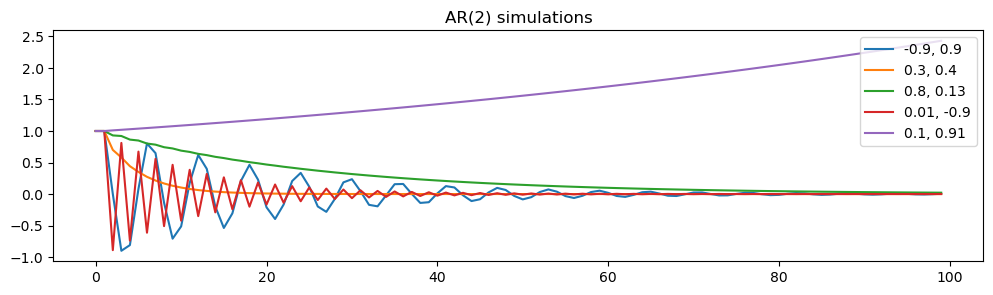

In [91]:
for i, arr in enumerate(lst_arrs):
    plt.plot(arr, label=f"{', '.join([str(i) for i in lst_As[i]])}")
plt.legend()
plt.title("AR(2) simulations")

# Question 8
"In VAR estimation, are the residuals supposed to be white noise or auto-regressive? What is the difference between weak white noise and strong white noise? Which are the null hypothesis and the statistics of the Ljung-Box or portmanteau test?"




In a VAR regression, the residuals are supposed to be white noise. If the residuals are autoregressive it would imply the VAR has been unsuccessful in extracting all the relationships between the variables and their lags. If the residuals were not white noise, a better order of VAR exists and the model could be estimated with greater explanatory power. If the residuals are autocorrelated, additional lags are added to the model. The number of lags can also be selected on the basis of the information criteria like AIC or SIC. 	No precautions are necessary if the residuals are correlated across equations

A key test for the VAR is to test whether there is autocorrelation in the residuals using a weak white noise test. Weak white noise requires that $\forall t, E(\epsilon_t)=0$, $Var(\epsilon_t)=\sigma^2_{\epsilon}$, $\forall t'≠t$,$Cov(\epsilon_{t}, \epsilon_{t'})=0$. Weak white noise residuals essentially means the residuals have constant variance, an expected value of 0 (mean 0) and for any two residuals, the covariance (and therefore correlation) is 0. By virtue of this, the residual at time t is not correlated with the residual at time t-1. Hence, no autocorrelation.

A strong white noise is a stochastic process of i.i.d. (identically, independently distributed) random variables. Strong white noise is a much stronger requirement than 0 covariance. The cumulative distribution function generating each observation must be identical and each lag must have a joint CDF with every other lag. Strong white noise imposes distributional assumptions over the whole history of the time series.

#### Ljung-Box Test
The null hypothesis of the Ljung-Box test is $H_0$: the data is independently distribution and the correlations are 0. If the residuals cannot reject the null hypothesis, the autocorrelation in the residuals is 0. This means that at a minimum the residuals are a white noise process. The alternative hypothesis $H_a$: The data is not independently distributed and there is autocorrelation in the residuals. A rejection of the null hypothesis of the Ljung-Box with regards to the residuals of a VAR model would imply the model is improperly specified and the lag length should be increased.






In VAR estimation, are the residuals supposed to be white noise or auto-regressive?
+ The resiudals are supposed to be white noise, if autocorrelated the VAR model does not fully capture the dynamics of the time series.
+ White noise residuals imply that the system of variables corresponds to the actual system generating the data in reality.

What is the difference between weak white noise and strong white noise? 
+ Weak white noise refers to uncorrelated variables, where correlation is a linear dependence as defined by the Pearson correlation coefficients. Consequently, weak white noise draws are linearily independent but may be linked through a non-linear function.
+ A stronger assumption is an indepednet identically distributed (iid) random white noise. Individual draws from such variable are independent of one another, thus there is no function linking the two. This explicitely includes non-linear functions, making this a stronger assumption than 1.

Which are the null hypothesis and the statistics of the Ljung-Box or portmanteau test?
+ The Ljung-Box statistic test for independence in the distribution



## Q11: Rolling window

In [105]:
sub = df[['pi_Y', 'ir']].dropna().copy()
sub['pi_Y'] = np.log(sub.pi_Y + abs(sub.pi_Y.min()) + .01)
# sub['pi_Y_resid'] = np.log(sub.pi_Y_resid + abs(sub.pi_Y_resid.min()) + .01)

In [109]:
window = 12*5

dict_coefs, dict_unit_root = {}, {}
for eow in [*range(window, len(sub),1)][:15]:
    dict_coefs[eow] = {}
    dict_unit_root[eow] = {}
    
    for col in sub:
        ar = ARIMA(sub.iloc[eow-window : eow][col], order=(1,0,0)).fit()
        dict_coefs[eow][col] = ar.params['ar.L1']
        
        adf, pval, _, _, _, _ = adfuller(sub.iloc[eow-window:eow][col], )
        if pval > .05:
            dict_unit_root[eow][col] = True
        else:
            dict_unit_root[eow][col] = False
            

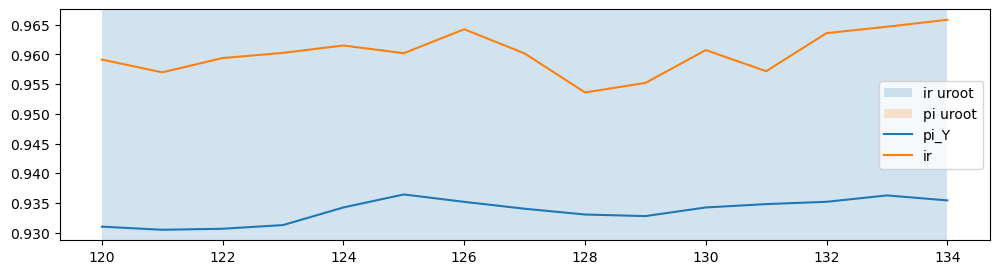

In [107]:
df_uroot = pd.DataFrame(dict_unit_root).T #columns=sub.iloc[window:].index).T
df_coefs = pd.DataFrame(dict_coefs).T #, columns=sub.iloc[window:].index).T
_ = (((df_uroot+1)- (df_uroot.shift(-1)+1)) != 0 ) + ( ((df_uroot+1)- (df_uroot.shift(-1)+1)) != 0) 
df_uroot += _

fig, ax = plt.subplots(1,1)
plt.fill_between(df_uroot.index, 0, 1, where=df_uroot.values[:, 1], alpha=.2, transform=ax.get_xaxis_transform(), label='ir uroot')
plt.fill_between(df_uroot.index, 0, 1, where=df_uroot.values[:, 0], alpha=.2, transform=ax.get_xaxis_transform(), label='pi uroot')
for col in df_coefs:
    plt.plot(df_coefs[col], label=col)
plt.legend()

In [108]:
df_coefs_AR = df_coefs.copy()

# Q12: 

In [44]:
sub = df[['pi_Y', 'ir']].dropna().copy()
sub['pi_Y'] = np.log(sub.pi_Y + abs(sub.pi_Y.min()) + .01)
sub = sm.add_constant(sub)

In [45]:
window = 12*3

dict_coefs = {}
for eow in [*range(window, len(sub),1)][:20]:
    dict_coefs[eow] = {}
    s = sub.iloc[eow-window : eow].copy()
    s['trend'] = [*range(window)]
    
    for col in sub.drop('const', axis=1):
        ols = OLS(s[col], exog=s[['const', 'trend']]).fit()
        dict_coefs[eow][col] = dict(ols.params)

<Axes: >

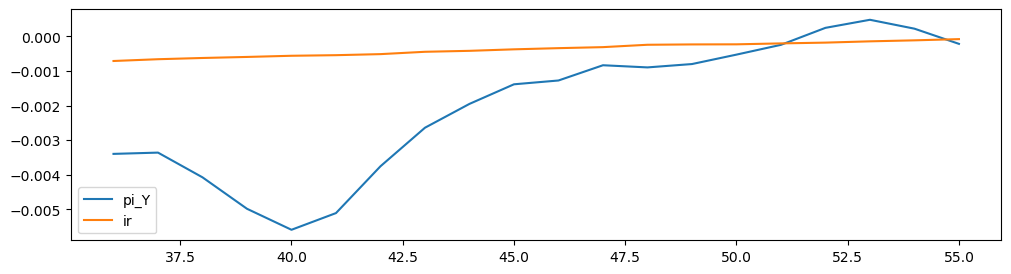

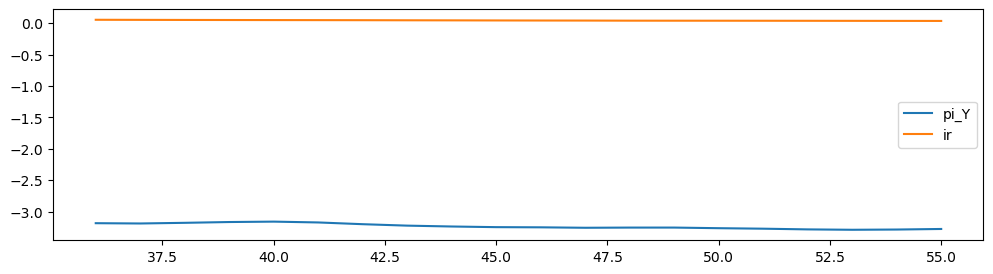

In [46]:
pd.DataFrame({key: {k: value[k]['trend'] for k in value.keys()} for key, value in dict_coefs.items()}).T.plot()
pd.DataFrame({key: {k: value[k]['const'] for k in value.keys()} for key, value in dict_coefs.items()}).T.plot()

## Q14 test for unit root

In [47]:
sub = df[['pi_Y', 'ir']].copy().dropna()

In [48]:
for col in sub:
    print(adf_test_summary(sub[col]))

-----------------------------------------------------------------------------
ADF Test PI_Y: H0 there is a unit root
-----------------------------------------------------------------------------
                        adf-stat  p-value  lags    obs     1%     5%    10%
constant                  -1.842    0.360  12.0  266.0 -3.455 -2.872 -2.573
constant trend            -1.954    0.626  12.0  266.0 -3.993 -3.427 -3.137
constant ltend, qtrend    -2.900    0.345  12.0  266.0 -4.415 -3.855 -3.567
none                      -0.686    0.418  12.0  266.0 -2.574 -1.942 -1.616


None
-----------------------------------------------------------------------------
ADF Test IR: H0 there is a unit root
-----------------------------------------------------------------------------
                        adf-stat  p-value  lags    obs     1%     5%    10%
constant                  -1.906    0.329   6.0  272.0 -3.455 -2.872 -2.572
constant trend            -1.236    0.903   6.0  272.0 -3.992 -3.427 -3.1

## Q15 cross correlation

In [49]:
sub = df[['pi_Y', 'ir']].dropna().copy()

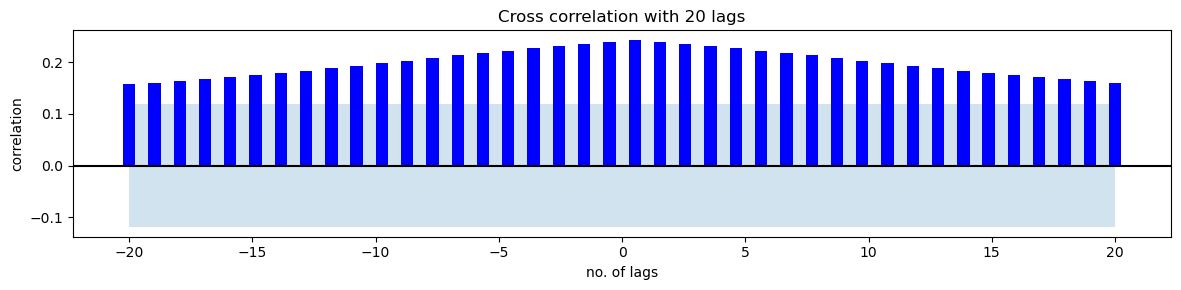

In [50]:
idx, corr, _, _, _ = cross_corr(sub.iloc[:,0], sub.iloc[:,1], lags=20)

In [51]:
pd.DataFrame(corr, index=idx);

# Q16:

In [ ]:
sub = df[['pi_Y', 'ir']].dropna().copy()
sub['pi_Y'] = np.log(sub.pi_Y + abs(sub.pi_Y.min()) + .01)

sub = sub.join(sub.shift(1).add_suffix('_lead1')).dropna()

In [ ]:
window = 12*5

dict_coefs, dict_unit_root = {}, {}
for eow in [*range(window, len(sub),1)][:15]:
    dict_coefs[eow] = {}
    dict_unit_root[eow] = {}

    s = sub.iloc[eow-window : eow]
    s = sm.add_constant(s)
    # s.dropna()
    
    ols_pi = OLS(endog=s['pi_Y_lead1'], exog=s[['pi_Y', 'ir']]).fit()
    ols_i = OLS(endog=s['ir_lead1'], exog=s[['pi_Y',]]).fit()

    ar_pi = ARIMA(ols_pi.resid, order=(1,0,0)).fit()
    ar_i = ARIMA(ols_i.resid, order=(1,0,0)).fit()

    dict_coefs[eow] = { 'ols_pi': ols_pi.params.to_dict(), 'ols_i': ols_i.params.to_dict(),
                       'ar_pi_params': ar_pi.params.to_dict(), 'ar_i_params': ar_i.params.to_dict()}
    
    for col in [('pi', ols_pi), ('i', ols_i)]:
        adf, pval, _, _, _, _ = adfuller(col[1].resid, )
        if pval > .05:
            dict_unit_root[eow][col[0]] = True
        else:
            dict_unit_root[eow][col[0]] = False

In [ ]:
df_uroot = pd.DataFrame(dict_unit_root).T 
_ = (((df_uroot+1)- (df_uroot.shift(-1)+1)) != 0 ) + ( ((df_uroot+1)- (df_uroot.shift(-1)+1)) != 0) 
df_uroot += _

In [ ]:
df_coefs = pd.DataFrame({k: v['ols_pi'] for k, v in dict_coefs.items()}).T.rename(columns={'pi_Y': 'A', 'ir': 'B',}) # 'ar.L1': 'F'})
df_coefs = df_coefs.join(pd.DataFrame({k: v['ols_i'] for k, v in dict_coefs.items()}).T.rename(columns={'pi_Y': 'F'}))
df_coefs = df_coefs.join(pd.DataFrame({k: v['ar_pi_params'] for k, v in dict_coefs.items()},).T.rename(columns={'ar.L1': 'rho_pi', 'sigma2': 'sigma_pi'}))
df_coefs = df_coefs.join(pd.DataFrame({k: v['ar_i_params'] for k, v in dict_coefs.items()},).T[['ar.L1', 'sigma2']].rename(columns={'ar.L1': 'rho_i', 'sigma2': 'sigma_i'}))
df_coefs = df_coefs.rename(columns={'pi_Y': 'A', 'ir': 'B', 'ar.L1': 'F'})
df_coefs['sigma_pi'] = np.sqrt(df_coefs.sigma_pi)
df_coefs['sigma_i'] = np.sqrt(df_coefs.sigma_i)

In [ ]:
fig, ax = plt.subplots(1,1)
plt.fill_between(df_uroot.index, 0, 1, where=df_uroot.values[:, 1], alpha=.2, transform=ax.get_xaxis_transform(), label='ir uroot')
plt.fill_between(df_uroot.index, 0, 1, where=df_uroot.values[:, 0], alpha=.2, transform=ax.get_xaxis_transform(), label='pi uroot')
for col in ['A', 'B', 'F']:
    ax.plot(df_coefs[col], label=col)
ax2 = ax.twinx()
for col in ['rho_pi', 'rho_i']:
    ax2.plot(df_coefs[col], label=col, linestyle='dashed')
fig.legend()

In [ ]:
df_coefs_ABF = df_coefs.copy()

# Q17:

In [ ]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax2.set_ylabel('AB+F')
ax2.plot((df_coefs['A'] + df_coefs['B'] * df_coefs['F']), label='AB+F')
ax.plot(df_coefs_AR['pi_Y'], label="$\lambda_{\pi}$", color='green')
ax.set_ylabel("$\lambda_{\pi}$",)
fig.legend()

## Q18

In [ ]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax2.plot((df_coefs['A'] + df_coefs['B'] * df_coefs['F']), label='AB+F', color='red')
ax2.set_ylabel('AB+F')
for col in ['A', 'B', 'F']:
    ax.plot(df_coefs[col], label=col)
ax.set_ylabel('A, B, F')
fig.legend()

## Q20

In [ ]:
sub = df[['pi_Y', 'ir']].copy().dropna()

In [ ]:
window = 12*5

dict_coefs, dict_unit_root = {}, {}
for eow in [*range(window, len(sub),1)][:15]:
    dict_coefs[eow] = {}
    dict_unit_root[eow] = {}

    s = sub.iloc[eow-window : eow]
    dict_coefs[eow] = { 'corr': np.correlate(s['ir'], s['pi_Y'])[0], 'std err': s['ir'].std() / s['pi_Y'].std() }

In [ ]:
df_coefs = pd.DataFrame(dict_coefs).T

In [ ]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax2.plot(df_coefs['std err'], label='std err')
ax.plot(df_coefs['corr'], label='corr', color='red')
ax.plot(df_coefs_ABF['F'], label='F', color='green')
fig.legend()

# Kalman filter

The Kalman Filter observes a state vector $\mathbf{X_t}$ of dimension $k$, evolving acording to some linear function. The system is also referred to as linear state space:
$$
    \mathbf{X}_{t+1} = \mathbf{A} \mathbf{X}_{t} + \mathbf{R} \mathbf{\epsilon_t}
$$
Propagating the system's transiton matrix $\mathbf{A}$ forward in time allows to forecast future states $\mathbf{\hat{X}}_{t+1}$.

The noise vector $\mathbf{\epsilon}_t \sim N(0, \mu^{\epsilon})$ is assumed to normally distributed and possibly correlated across the state dimension. The selection matrix $\mathbf{R}$ ensures that errors are mapped to states $\mathbf{X}_t$.

The filter distinguishes between observed $o$ and hidden states $h$. Toghether hidden and observed states form state vector $\mathbf{X}_t$, such that $o+h = k$. Observed states are met by observation $\mathbf{S}^{obs}_t$, which are subject to Gaussian noise. 
$$ \mathbf{S}^{obs}_t = \mathbf{S}^{true}_t + \mathbf{u}_t \sim N(0, \mu^{obs}) $$
Observed states $\mathbf{S}^{obs}_t$ are mapped to the state vector $\mathbf{X}_t$ through the design matrix $\mathbf{D}$.
$$ \mathbf{S}_t = \mathbf{D} \mathbf{X}_t $$

Applied to the context of this work the specific matrices are provided below:


In [ ]:
b = sp.symbols("x")

In [ ]:
_b = sp.lambdify(b, b+1)

In [ ]:
_b(1)

In [ ]:
A, B, F, rho_pi, rho_i, e_pi, e_i, u_pi, u_i, pi_t, i_t, pi_obs_t, i_obs_t lst_sp_expressions

In [ ]:
lst_sp_expressions = sp.symbols(
    ['A', 'B', 'F', 'rho^pi_u', 'rho^i_u', '\epsilon^{\pi}_{t+1}', '\epsilon^{i}_{t+1}',
     'u^{\pi}_t', 'u^i_t', '\pi_t', 'i_t', '\pi^{obs}_t', 'i^{obs}_t'])
A, B, F, rho_pi, rho_i, e_pi, e_i, u_pi, u_i, pi_t, i_t, pi_obs_t, i_obs_t = lst_sp_expressions

# state = sp.Matrix([pi_t, i_t, u_pi, u_i])
# transition = sp.Matrix([[A, B, rho_pi, 0], [F, 0, 0, rho_i], [0, 0, rho_pi, 0], [0, 0, 0, rho_i]])
# design = sp.Matrix([[1, 0, 0, 0], [0, 1, 0, 0]]) # measurment to state vector
# selection = sp.Matrix([[1,0], [0, 1], [1, 0], [0, 1]]) # noise to state
# measurment = sp.Matrix([pi_obs_t, i_obs_t])
# errors = sp.Matrix([e_pi, e_i])
_ = [
    sp.Matrix([pi_t, i_t, u_pi, u_i]), # states
    sp.Matrix([[A, B, rho_pi, 0], [F, 0, 0, rho_i], [0, 0, rho_pi, 0], [0, 0, 0, rho_i]]), # transition
    sp.Matrix([[1, 0, 0, 0], [0, 1, 0, 0]]), # measurment to state vector
    sp.Matrix([[1,0], [0, 1], [1, 0], [0, 1]]), # noise to state
    sp.Matrix([pi_obs_t, i_obs_t]), # observed
    sp.Matrix([e_pi, e_i]), # shocks
]
dict_sp_matrices = {k: _[i] for i, k in enumerate(['state', 'transition', 'design', 'selection', 'measurement', 'shocks'])}
dict_sp_lambdas = {k: sp.lambdify(list(v.free_symbols), v) for k, v in dict_sp_matrices.items()}

In [ ]:
for k, v in dict_sp_matrices.items():
    print(k,)
    display(v)
    print('\n')

In [ ]:
dict_sp_matrices['transition'] @ dict_sp_matrices['state'] + dict_sp_matrices['selection'] @ dict_sp_matrices['shocks']

In [ ]:
dict_sp_matrices['design'] @ dict_sp_matrices['state']

### Artificial Data Simulation

A first section will be analysing artificial data. This exercise is meant to reflect the filter's ability to detect a negative B coefficient in the theoretical setup. The Central Bank is "leaning" into the wind, overreacting to inflation to drive it down.

In [ ]:
N = 150

A_true, B_true, F_true = .7, -.2, 1.5
rho_u_pi_true, rho_u_i_true = .3, -.1
epsilon_u_pi_true, epsilon_u_i_true = 0.4, .05

dict_true_coefs = dict(zip(['A', 'B', 'F', 'rho_u_pi', 'rho_u_i', 'epsilon_u_pi', 'epsilon_u_i'],
                           [A_true, B_true, F_true, rho_u_pi_true, rho_u_i_true, epsilon_u_pi_true, epsilon_u_i_true]))

In [ ]:
dist_shocks = scipy.stats.multivariate_normal(mean=[0, 0], cov=[[epsilon_u_pi, 0], [0, epsilon_u_i]], )
a = dist_shocks.rvs(1_000)
plt.plot(a[:,0], a[:,1], lw=0, marker='.')
plt.xlabel("Shock $\epsilon^{pi}_t$")
plt.ylabel("Shock $\epsilon^{i}_t$")
plt.tight_layout()

check stability through eigenvalues

In [ ]:
e,_ = np.linalg.eig(dict_sp_lambdas['transition'](rho_u_pi_true, A_true, rho_u_pi_true, F_true, B_true))
np.abs(e) <= 1

In [ ]:
arr_states = np.ones((N, 4))
arr_shocks = dist_shocks.rvs(N)

for i in range(1, N):
    arr_states[i] = dict_sp_lambdas['transition'](rho_u_pi_true, A_true, rho_u_pi_true, F_true, B_true) @ arr_states[i-1] \
                    + dict_sp_lambdas['selection']() @ arr_shocks[i]

This is one possible path of reality under the given parameters. Due to the stochastic nature of the system there is not one deterministic path. However, regardless of the exact path of the system the Kalman Filter should be able to retrieve its generating parameters.

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(14,5))
ax[0].plot(arr_states[:,:2])
ax[0].legend(['pi', 'i'])
ax[1].plot(arr_states[:,2:],)
ax[1].legend(['u_pi', 'u_i'])

## PYMC

In [ ]:
jax.config.update("jax_platform_name", "cpu")
numpyro.set_host_device_count(4)

In [ ]:
seed = sum(map(ord, "custom statespace model"))
rng = np.random.default_rng(seed)
matrix_names = [
    "initial_state",
    "initial_state_cov",
    "state_intercept",
    "obs_intercept",
    "transition",
    "design",
    "selection",
    "obs_cov",
    "state_cov",
]

In [ ]:
# define Kalman filter

In [ ]:
class ABFKalmanFilter(PyMCStateSpace):
    def __init__(self):
        k_states = 4  # size of the state vector x
        k_posdef = 2  # number of shocks (size of the state covariance matrix Q)
        k_endog = 2 # number of observed states

        super().__init__(k_endog=k_endog, k_states=k_states, k_posdef=k_posdef,)

    def make_symbolic_graph(self):
        # initial values
        x0 = self.make_and_register_variable("x0", shape=(4,))
        P0 = self.make_and_register_variable("P0", shape=(4, 4))

        # policy parameters
        A = self.make_and_register_variable("A", shape=(1,))
        B = self.make_and_register_variable("B", shape=(1,))
        F = self.make_and_register_variable("F", shape=(1,))

        # shock autoregressive parameters
        rhos = self.make_and_register_variable("rho", shape=(2,))

        # shock and observation covariance
        cov_u = self.make_and_register_variable("cov_u", shape=(self.k_posdef,self.k_posdef))
        cov_o = self.make_and_register_variable("cov_o", shape=(self.k_endog,self.k_endog))

        # F -> transition matrix
        self.ssm["transition", :, :] = np.zeros((self.k_states, self.k_states)) #np.eye(2, k=-1)
        self.ssm["transition", 0, 0] = A[0]
        self.ssm["transition", 0, 1] = B[0]
        self.ssm["transition", 1, 0] = F[0]
        self.ssm["transition", 0, 2] = rhos[0]
        self.ssm["transition", 2, 2] = rhos[0]
        self.ssm["transition", 1, 3] = rhos[1]
        self.ssm["transition", 3, 3] = rhos[1]
        
        # R -> noise on sensor where
        self.ssm["selection", 0, 0] = 1
        self.ssm["selection", 1, 1] = 1
        self.ssm["selection", 2, 0] = 1
        self.ssm["selection", 3, 1] = 1

        # H -> measurement u to state vector
        self.ssm["design", 0, 0] = 1
        self.ssm["design", 1, 1] = 1        

        # initial values
        self.ssm["initial_state", :] = x0
        self.ssm["initial_state_cov", :, :] = P0

        # covariances
        self.ssm["state_cov", :, :] = cov_u
        self.ssm["obs_cov", :, :] = cov_o

    @property
    def param_names(self):
        return ["x0", "P0", "A", "B", "F", "rho", "cov_u", "cov_o", ]

    @property
    def state_names(self):
        return ["pi", "i", "u_pi", "u_i"]

    @property
    def shock_names(self):
        return ["epsilon_pi", "epsilon_i"]

    @property
    def observed_states(self):
        # Inspired, I know
        return ["pi", "i"]

    # @property
    # def param_dims(self):
    #     return {
    #         "x0": (ALL_STATE_DIM,),
    #         "P0": (ALL_STATE_DIM, ALL_STATE_AUX_DIM),
    #         "A": ("abf_dim",),
    #         "B": ("abf_dim",),
    #         "F": ("abf_dim",),
            # "rhow": ("shock_lags"),
    
    #     }

    @property
    def coords(self):
        coords = make_default_coords(self)
        # coords.update({"abf_dim": [1]})
        # coords.update({"shock_lags": [1]})

        return coords

    @property
    def param_info(self):
        info = {
            "x0": {
                "shape": (self.k_states,),
                "constraints": "None",
            },
            "P0": {
                "shape": (self.k_states, self.k_states),
                "constraints": "Positive Semi-definite",
            },
            "A": {
                "shape": (1,),
                "constraint": "None",
            },
            "B": {
                "shape": (1,),
                "constraint": "None",
            },
            "F": {
                "shape": (1,),
                "constraint": "None",
            },
            "cov_u": {
                "shape": (self.k_posdef, self.k_posdef),
                "constraint": "Positive Semi-definite",
            },
            "cov_o": {
                "shape": (self.k_endog, self.k_endog),
                "constraint": "Positive Semi-definite",
            },
            "rho": {
                "shape": (self.k_posdef,),
                "constraint": "None",
            }

        }

        for name in self.param_names:
            info[name]["dims"] = self.param_dims[name]

        return info
        

In [ ]:
# define Bayesian estimation prior

In [ ]:
def get_KF_pymc_mod():
    kf_test = ABFKalmanFilter()
    
    with pm.Model(coords=kf_test.coords) as pymc_mod:
        x0 = pm.Deterministic("x0", pt.zeros(4,),dims=["state"],)
        P0 = pm.Deterministic("P0", pt.eye(4) * 10, dims=["state", "state_aux"])
        
        A = pm.Normal("A", mu=0, sigma=.5, shape=(1,),)
        B = pm.Normal("B", mu=0, sigma=.5, shape=(1,),)
        F = pm.Normal("F", mu=0, sigma=.5, shape=(1,),)
        
        rho = pm.Beta("rho", 1, 3, shape=(2,),)
    
        chol, corr, stds = pm.LKJCholeskyCov("chol_u", n=2, eta=5.0, 
                                             sd_dist=pm.HalfNormal.dist(1.5, shape=2))
        cov_u = pm.Deterministic("cov_u", chol.dot(chol.T))
        stds_u = pm.Deterministic("stds_u", stds)
        corr_u = pm.Deterministic("corr_u", corr)
    
        chol, corr, stds = pm.LKJCholeskyCov("chol_o", n=2, eta=5.0, 
                                             sd_dist=pm.HalfNormal.dist(.5, shape=2))
        cov_o = pm.Deterministic("cov_o", chol.dot(chol.T))
        stds_o = pm.Deterministic("stds_o", stds)
        corr_o = pm.Deterministic("corr_o", corr)
    return kf_test, pymc_mod

## test with sample data

In [ ]:
with mod_kf_test:
    kf_test.build_statespace_graph(data=arr_states[:,:2], mode="JAX",  save_kalman_filter_outputs_in_idata=True)
    idata = pm.sample(chains=4, nuts_sampler="numpyro", )

In [ ]:
import arviz as az
lst_params = ['A', 'B', 'F', 'rho', 'stds_u', 'stds_o']
az.plot_trace(idata, var_names=lst_params)
plt.tight_layout()
;

In [ ]:
az.plot_posterior(idata, var_names=['A', 'B', 'F', 'rho', 'stds_u', 'stds_o'],
                  ref_val=[
                      dict_true_coefs[i] if i!=0 else i for i in 
                      ['A', 'B', 'F', 'rho_u_pi', 'rho_u_i', 'epsilon_u_pi', 'epsilon_u_i']
                  ] + [*np.cov(arr[:,0], arr[:,1]).diagonal()],
                  figsize=(14,8),
                 );
plt.tight_layout()

In [ ]:
plot_KF_states(idata, kf_test, arr_states[:,:2], filtered='filtered')

## true data

In [ ]:
sub = df[['pi_Y', 'ir']].dropna().copy() 
sub.plot()
data = sub.values

In [ ]:
kf_real, mod_kf_real = get_KF_pymc_mod()

In [ ]:
with mod_kf_real:
    kf_real.build_statespace_graph(data=data, mode="JAX",  save_kalman_filter_outputs_in_idata=True)
    idata = pm.sample(chains=4, nuts_sampler="numpyro", )

In [ ]:
import arviz as az
lst_params = ['A', 'B', 'F', 'rho', 'stds_u', 'stds_o']
az.plot_trace(idata, var_names=lst_params)
plt.tight_layout()
;

In [ ]:
plot_KF_states(idata, kf_test, arr, filtered='filtered')

# References

Bureau of Labor Statistics (2022). What is seasonal adjustment? : U.S. Bureau of Labor Statistics. [online] Bls.gov. Available at: https://www.bls.gov/cps/seasfaq.htm [Accessed 31 Mar. 2024].

CEPR. (2024). Monetary policy responses to the post-pandemic inflation: Challenges and lessons for the future. [online] Available at: https://cepr.org/voxeu/columns/monetary-policy-responses-post-pandemic-inflation-challenges-and-lessons-future [Accessed 1 Apr. 2024].


EUROSTAT (2024) Harmonised index of consumer prices (HICP) (prc_hicp), Harmonised index of consumer prices (HICP) (PRC_HICP). Available at: https://ec.europa.eu/eurostat/cache/metadata/en/prc_hicp_esms.htm (Accessed: 30 March 2024). 

Hodrick, R.J. and Prescott, E.C. (1997). Postwar U.S. Business Cycles: An Empirical Investigation. Journal of Money, Credit and Banking, 29(1), p.1. doi:https://doi.org/10.2307/2953682.

OECD (2019). Trend Estimation Method. [online] Oecd-ilibrary.org. Available at: https://www.oecd-ilibrary.org/sites/361fabc3-en/index.html?itemId=/content/component/361fabc3-en [Accessed 31 Mar. 2024].

Stock, J.H. and Watson, M.W., 2020. Introduction to econometrics. Pearson.



‌